In [ ]:
import numpy as np
import itertools
import os
import pandas as pd
import seaborn as sea

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE

import xgboost as xgb
from xgboost import plot_importance

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
sea.set_style("darkgrid")

In [ ]:
data = pd.read_csv("/content/Maternal Health Risk Data Set.csv")

data.head(10).style.set_precision(2). \
                    set_properties(**{"min-width": "60px"}). \
                    set_properties(**{"color": "#111111"}). \
                    set_properties(**{"text-align": "center"}). \
                    set_table_styles([
                          {"selector": "th",
                           "props": [("font-weight", "bold"),
                                     ("font-size", "12px"),
                                     ("text-align", "center")]},
                          {"selector": "tr:nth-child(even)",
                           "props": [("background-color", "#f2f2f2")]},
                          {"selector": "tr:nth-child(odd)",
                           "props": [("background-color", "#fdfdfd")]},
                          {"selector": "tr:hover",
                           "props": [("background-color", "#bcbcbc")]}])

<ipython-input-3-8d057fe1931b>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.head(10).style.set_precision(2). \


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.00,86,high risk
1,35,140,90,13.00,98.00,70,high risk
2,29,90,70,8.00,100.00,80,high risk
3,30,140,85,7.00,98.00,70,high risk
4,35,120,60,6.10,98.00,76,low risk
5,23,140,80,7.01,98.00,70,high risk
6,23,130,70,7.01,98.00,78,mid risk
7,35,85,60,11.00,102.00,86,high risk
8,32,120,90,6.90,98.00,70,mid risk
9,42,130,80,18.00,98.00,70,high risk


In [ ]:
data['RiskLevel'].replace(['high risk', 'mid risk', 'low risk'],
                        [2, 1, 0], inplace=True)

In [ ]:
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0


In [ ]:
pd.options.mode.chained_assignment = None

data_X = data.loc[:, data.columns != "RiskLevel"]
data_Y = data[["RiskLevel"]]

print("data_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()

data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 47.7 KB

data_Y info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   RiskLevel  1014 non-null   int64
dtypes: int64(1)
memory usage: 8.0 KB


In [ ]:
data_Y["RiskLevel"].value_counts()

0    406
1    336
2    272
Name: RiskLevel, dtype: int64

# Split Data

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y,test_size=0.2,stratify=data_Y,random_state=0)
train_X.reset_index(drop=True, inplace=True);
test_X.reset_index(drop=True, inplace=True);
train_Y.reset_index(drop=True, inplace=True);
test_Y.reset_index(drop=True, inplace=True);

# Visualization and checking for outliers

In [ ]:
def plots(feature):
    fig = plt.figure(constrained_layout = True, figsize=(10,3))
    gs = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)

    ax1 = fig.add_subplot(gs[0,:3])    
    sea.distplot(train_X.loc[train_Y["RiskLevel"]==0,feature],
                 kde = False, color = "#004a4d", norm_hist=False,
                 hist_kws = dict(alpha=0.8), bins=40,
                 label="Low Risk", ax=ax1);
    sea.distplot(train_X.loc[train_Y["RiskLevel"]==1,feature],
                 kde = False, color = "#7d0101", norm_hist=False,
                 hist_kws = dict(alpha=0.6), bins=40,
                 label="Mid Risk", ax=ax1);
    sea.distplot(train_X.loc[train_Y["RiskLevel"]==2,feature],
                 kde = False, color = "#7d0121", norm_hist=False,
                 hist_kws = dict(alpha=0.4), bins=40,
                 label="High Risk", ax=ax1);
    ax2 = fig.add_subplot(gs[0,3])    
    sea.boxplot(train_X[feature], orient="v", color = "#989100",
                width = 0.2, ax=ax2);
    
    ax1.legend(loc="upper right");

# Feature 0 : Age

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


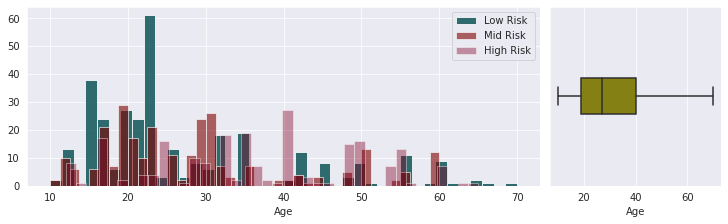

In [ ]:
plots("Age")

In [ ]:
Q1 = train_X["Age"].quantile(0.25)
Q3 = train_X["Age"].quantile(0.75)
q95th = train_X["Age"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Age"] = np.where(train_X["Age"] > UW,
                                  q95th, train_X["Age"])

# Feature 1 : SystolicBP

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


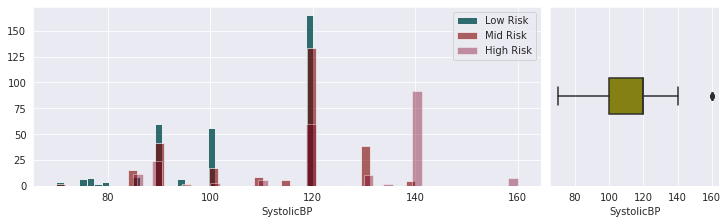

In [ ]:
plots("SystolicBP")

In [ ]:
med = train_X["SystolicBP"].median()
train_X["SystolicBP"] = np.where(train_X["SystolicBP"] == 0, med, train_X["SystolicBP"])

# Feature 2 : DiastolicBP

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


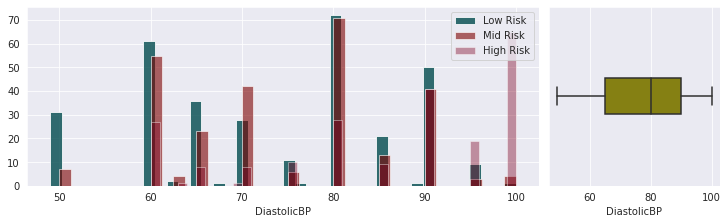

In [ ]:
plots("DiastolicBP")

In [ ]:
med = train_X["DiastolicBP"].median()
q5th = train_X["DiastolicBP"].quantile(0.05)
q95th = train_X["DiastolicBP"].quantile(0.95)
Q1 = train_X["DiastolicBP"].quantile(0.25)
Q3 = train_X["DiastolicBP"].quantile(0.75)
IQR = Q3 - Q1
LW = Q1 - 1.5*IQR
UW = Q3 + 1.5*IQR

train_X["DiastolicBP"] = np.where(train_X["DiastolicBP"] == 0,
                                    med, train_X["DiastolicBP"])
train_X["DiastolicBP"] = np.where(train_X["DiastolicBP"] < LW,
                                    q5th, train_X["DiastolicBP"])
train_X["DiastolicBP"] = np.where(train_X["DiastolicBP"] > UW,
                                    q95th, train_X["DiastolicBP"])

# Feature 3 : BS

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


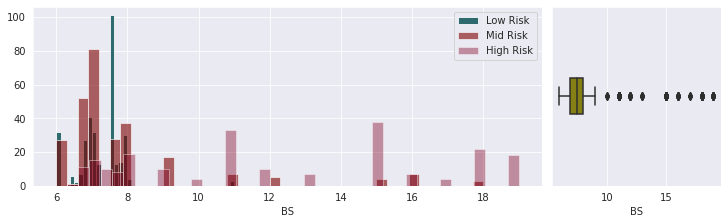

In [ ]:
plots("BS")

In [ ]:
med = train_X["BS"].median()
q95th = train_X["BS"].quantile(0.95)
Q1 = train_X["BS"].quantile(0.25)
Q3 = train_X["BS"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["BS"] = np.where(train_X["BS"] == 0,
                                    med, train_X["BS"])
train_X["BS"] = np.where(train_X["BS"] > UW,
                                    q95th, train_X["BS"])

# Feature 4 : Body Temp

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


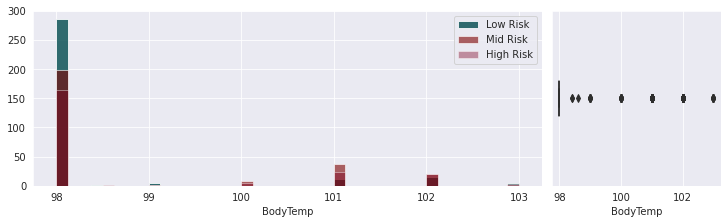

In [ ]:
plots("BodyTemp")

In [ ]:
q60th = train_X["BodyTemp"].quantile(0.60)
q95th = train_X["BodyTemp"].quantile(0.95)
Q1 = train_X["BodyTemp"].quantile(0.25)
Q3 = train_X["BodyTemp"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["BodyTemp"] = np.where(train_X["BodyTemp"] == 0,
                              q60th, train_X["BodyTemp"])
train_X["BodyTemp"] = np.where(train_X["BodyTemp"] > UW,
                              q95th, train_X["BodyTemp"])

# Feature 5 : HeartRate

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


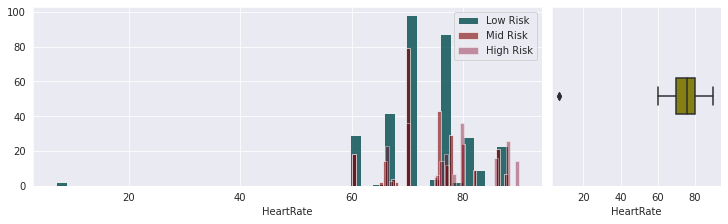

In [ ]:
plots("HeartRate")

In [ ]:
med = train_X["HeartRate"].median()
q95th = train_X["HeartRate"].quantile(0.95)
Q1 = train_X["HeartRate"].quantile(0.25)
Q3 = train_X["HeartRate"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["HeartRate"] = np.where(train_X["HeartRate"] == 0,
                          med, train_X["HeartRate"])
train_X["HeartRate"] = np.where(train_X["HeartRate"] > UW,
                          q95th, train_X["HeartRate"])

# Standardization

In [ ]:
feature_names = train_X.columns

scaler = StandardScaler()

# fit to train_X
scaler.fit(train_X)

# transform train_X
train_X = scaler.transform(train_X)
train_X = pd.DataFrame(train_X, columns = feature_names)

# transform test_X
test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns = feature_names)

# Correlation Analysis

<ipython-input-29-f19a24d61cbe>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))


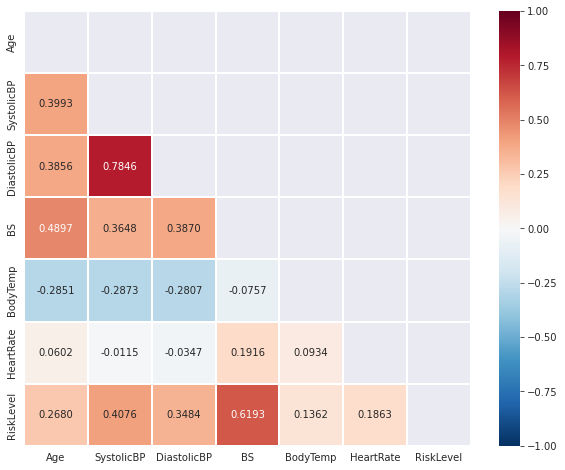

In [ ]:
corr_matrix = pd.concat([train_X, train_Y], axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(10,8))
sea.heatmap(corr_matrix,annot=True, fmt=".4f",
            vmin=-1, vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");

# Feature Importance

In [ ]:
# logistic regression with l1 penalty - embedded method
lr1 = LogisticRegression(random_state=0, penalty="l1",
            class_weight="balanced", solver="saga", max_iter=5000)
lr1.fit(train_X, train_Y.values.ravel())

lr1.coef_

array([[ 0.03484355, -0.98932182,  0.        , -0.87495112, -0.54582809,
        -0.21844554],
       [ 0.        ,  0.        , -0.46146147,  0.        ,  0.        ,
         0.        ],
       [-0.41152647,  0.39018511,  0.3156702 ,  1.39604953,  0.60284668,
         0.05976137]])

In [ ]:
# logistic regression with l2 penalty - embedded method
lr2 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
lr2.fit(train_X, train_Y.values.ravel())

lr2.coef_

array([[ 0.17087221, -0.79634197,  0.0450246 , -1.05347992, -0.56901326,
        -0.1726299 ],
       [ 0.12884095,  0.19991549, -0.41955383, -0.17499595, -0.0208758 ,
         0.05153834],
       [-0.29971316,  0.59642648,  0.37452923,  1.22847587,  0.58988906,
         0.12109156]])

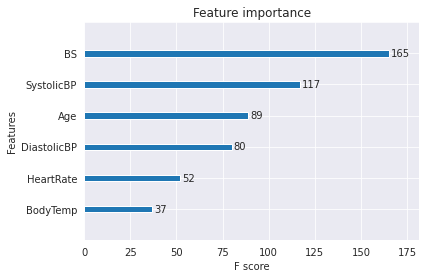

In [ ]:
gb = xgb.XGBClassifier(booster="gbtree",
                      learning_rate=0.15,
                      max_depth=4,
                      n_estimators=20,
                      random_state=0)
gb.fit(train_X, train_Y.values.ravel())

plot_importance(gb);

In [ ]:
lr3 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
rfe_lr3 = RFE(lr3, n_features_to_select=7)
rfe_lr3.fit(train_X, train_Y.values.ravel())

print(rfe_lr3.support_)

[ True  True  True  True  True  True]


# Train Model

In [ ]:
clf = MLPClassifier(solver="adam", max_iter=5000, activation = "relu",
                    hidden_layer_sizes = (12),                      
                    alpha = 0.01,
                    batch_size = 64,
                    learning_rate_init = 0.001,
                    random_state=2)

clf.fit(train_X, train_Y.values.ravel());

# Test Model

In [ ]:
print(classification_report(test_Y, clf.predict(test_X),
                            digits = 4,
                            target_names=["High Risk",
                                          "Mid Risk",
                                          "Low Risk"]))

              precision    recall  f1-score   support

   High Risk     0.5526    0.7778    0.6462        81
    Mid Risk     0.3878    0.2836    0.3276        67
    Low Risk     0.8750    0.6364    0.7368        55

    accuracy                         0.5764       203
   macro avg     0.6051    0.5659    0.5702       203
weighted avg     0.5856    0.5764    0.5656       203

